In [1]:
!pip install datasets

In [ ]:
import os
import json
from datasets import load_dataset
from PIL import Image
from tqdm import tqdm

TRAIN_DIR = "/kaggle/working/plan_b_train_data"
TARGET_SIZE = 512  # SD 1.5 native resolution (half of SSD-1B, far less upscaling)
os.makedirs(TRAIN_DIR, exist_ok=True)

# 1. Download directly from Hugging Face
print("Downloading pixel-art-nouns-2k from Hugging Face...")
dataset = load_dataset("jiovine/pixel-art-nouns-2k", split="train")

metadata = []
print(f"Resizing {len(dataset)} images using Nearest Neighbor to {TARGET_SIZE}x{TARGET_SIZE}...")

for i, item in enumerate(tqdm(dataset)):
    try:
        # HF datasets automatically load images as PIL objects
        img = item['image']

        # The text column in this specific dataset is usually 'text'
        caption = item['text']

        if img.mode != "RGB":
            img = img.convert("RGB")

        # Nearest Neighbor resize to keep pixel art edges sharp (no blurring)
        img_resized = img.resize((TARGET_SIZE, TARGET_SIZE), resample=Image.NEAREST)

        filename = f"noun_{i}.png"
        img_resized.save(os.path.join(TRAIN_DIR, filename), "PNG")

        # Style trigger tokens prepended to every caption
        #full_caption = "pixel art, 16-bit, sprite, " + str(caption)
        metadata.append({"file_name": filename, "text": caption})

    except Exception as e:
        print(f"Skipping image {i} due to error: {e}")

# 2. Save the JSONL metadata file for the trainer
with open(os.path.join(TRAIN_DIR, "metadata.jsonl"), 'w') as f:
    for entry in metadata:
        f.write(json.dumps(entry) + "\n")

print(f"Data Ready! {len(metadata)} images saved to {TRAIN_DIR}")


README.md:   0%|          | 0.00/400 [00:00<?, ?B/s]

data/train-00000-of-00001-6c76be0228a05d(…):   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Upscaling 2000 images using Nearest Neighbor...


100%|██████████| 2000/2000 [01:17<00:00, 25.90it/s]

Plan B Data Ready! Saved to /kaggle/working/plan_b_train_data


In [3]:
# import matplotlib.pyplot as plt
# from PIL import Image
# import os

# # Path to your newly processed Plan B dataset
# TRAIN_DIR = "/kaggle/working/plan_b_train_data"

# # Grab the very first image we processed
# sample_image_path = os.path.join(TRAIN_DIR, "noun_0.png")

# if os.path.exists(sample_image_path):
#     img = Image.open(sample_image_path)
    
#     # Display the image
#     plt.figure(figsize=(8, 8))
#     plt.imshow(img)
#     plt.title(f"Upscaled Resolution: {img.size[0]}x{img.size[1]} pixels\n(Notice the crisp edges!)", fontsize=14)
#     plt.axis('off') # Hides the axis numbers for a cleaner look
#     plt.show()
# else:
#     print("Image not found. Make sure the Plan B Data Prep cell has finished running completely!")

In [ ]:
# Install the necessary libraries
!pip install -U -q diffusers accelerate transformers peft bitsandbytes
!pip install -q wandb  # For metric tracking

# Download the official SD 1.5 LoRA training script (NOT the sdxl variant)
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/train_text_to_image_lora.py


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 32.9 MB/s eta 0:00:00:00:0100:01
--2026-02-21 05:20:54--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/train_text_to_image_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56285 (55K) [text/plain]
Saving to: ‘train_text_to_image_lora_sdxl.py’

train_text_to_image 100%[===================>]  54.97K  --.-KB/s    in 0.01s   

2026-02-21 05:20:54 (4.76 MB/s) - ‘train_text_to_image_lora_sdxl.py’ saved [56285/56285]



In [5]:
# 1. Uninstall existing version to avoid conflicts
!pip uninstall -y diffusers

# 2. Install the latest "dev" version from source
!pip install git+https://github.com/huggingface/diffusers

# 3. Ensure other dependencies are up to date for SSD-1B
!pip install -U -q accelerate transformers peft bitsandbytes

Found existing installation: diffusers 0.36.0
Uninstalling diffusers-0.36.0:
  Successfully uninstalled diffusers-0.36.0
  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-61l1fwpq
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-61l1fwpq
  Resolved https://github.com/huggingface/diffusers to commit a80b19218b4bd4faf2d6d8c428dcf1ae6f11e43d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.37.0.dev0-py3-none-any.whl size=4930095 sha256=ac575627e3027c9677e510061817655bb9dc27b6f354df32fd5bc57827e00ced
  Stored in directory: /tmp/pip-ephem-wheel-cache-p2h9tlik/wheels/90/d4/44/a58bc00fb405fefb633b0d9d2307f6e3aec6cc1775d82555d3
Successfully built diffusers


In [ ]:
!accelerate launch --num_processes=1 train_text_to_image_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --train_data_dir="/kaggle/working/plan_b_train_data" \
  --caption_column="text" \
  --resolution=512 \
  --mixed_precision="fp16" \
  --train_batch_size=2 \
  --gradient_accumulation_steps=4 \
  --learning_rate=1e-4 \
  --rank=16 \
  --max_train_steps=1000 \
  --checkpointing_steps=100 \
  --validation_prompt="pixel art, 16-bit, sprite, an owl" \
  --validation_epochs=1 \
  --num_validation_images=4 \
  --output_dir="/kaggle/working/court_of_owls_lora_sd15" \
  --seed=42 \
  --report_to="tensorboard"


The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
tokenizer_config.json: 100%|███████████████████| 737/737 [00:00<00:00, 3.22MB/s]
vocab.json: 1.06MB [00:00, 29.3MB/s]
merges.txt: 525kB [00:00, 106MB/s]
config.json: 100%|█████████████████████████████| 560/560 [00:00<00:00, 3.57MB/s]
You are using a model of type `clip_text_model` to instantiate a model of type ``. This may be expected if you are loading a check

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--segmind--SSD-1B/snapshots/60987f37e94cd59c36b1cba832b9f97b57395a10/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/517 [00:00<?, ?it/s]

CLIPTextModelWithProjection LOAD REPORT from: /root/.cache/huggingface/hub/models--segmind--SSD-1B/snapshots/60987f37e94cd59c36b1cba832b9f97b57395a10/text_encoder_2
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related p

  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl.py:748: FutureWarning: `upcast_vae` is deprecated and will be removed in version 1.0.0. `upcast_vae` is deprecated. Please use `pipe.vae.to(torch.float32)`. For more details, please refer to: https://github.com/huggingface/diffusers/pull/12619#issue-3606633695.
  deprecate(


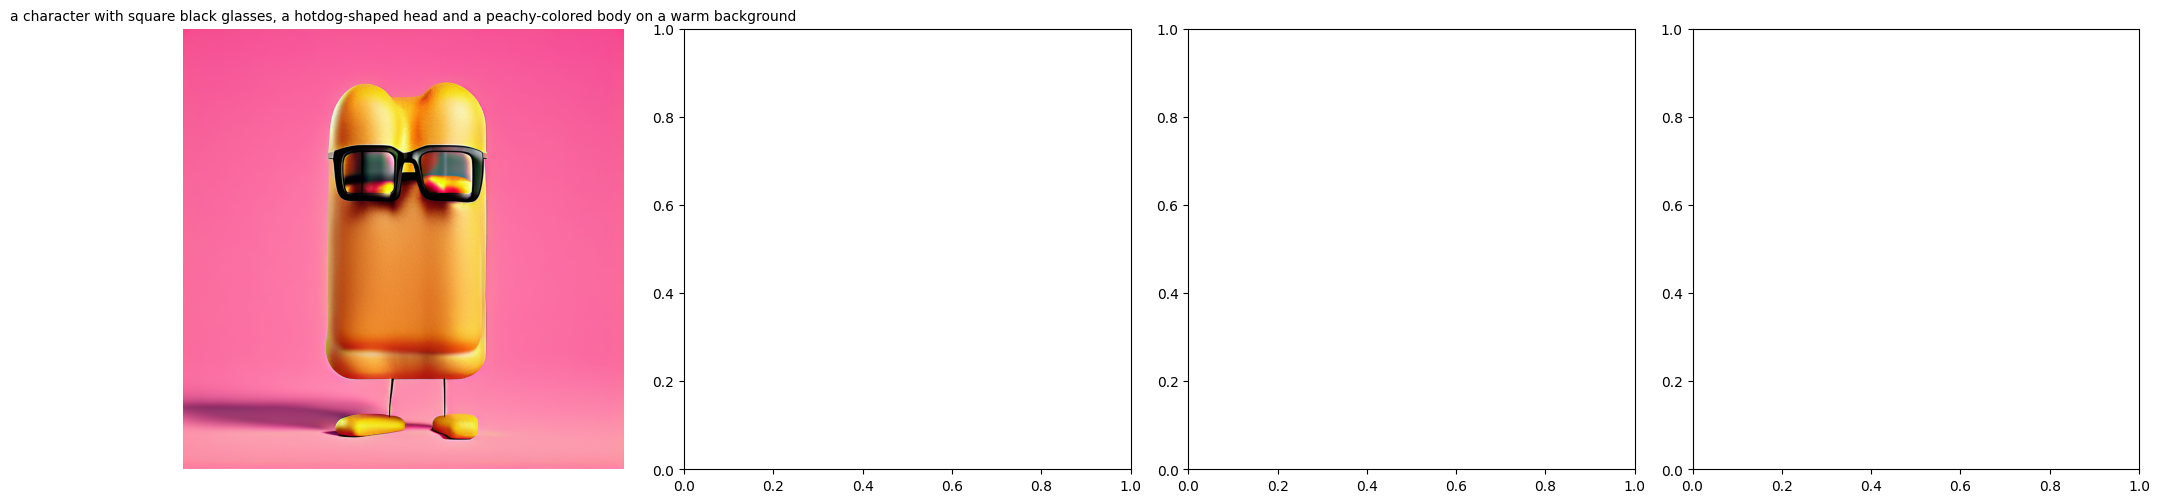

Images saved to: /kaggle/working/output/validation_results.png


In [ ]:
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import os

# Load SD 1.5 base model
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
)
pipe.to("cuda")

# Load your trained LoRA weights
pipe.load_lora_weights("/kaggle/working/court_of_owls_lora_sd15/pytorch_lora_weights.safetensors")

# Generate test images
prompts = [
    "pixel art, 16-bit, sprite, a character with square black glasses, a hotdog-shaped head and a peachy-colored body on a warm background"
]

images = []
for prompt in prompts:
    image = pipe(
        prompt=prompt,
        num_inference_steps=25,
        guidance_scale=7.5,
        height=512,
        width=512,
        generator=torch.Generator("cuda").manual_seed(42)
    ).images[0]
    images.append(image)

# Display results
fig, axes = plt.subplots(1, len(images), figsize=(6 * len(images), 6))
if len(images) == 1:
    axes = [axes]
for ax, img, prompt in zip(axes, images, prompts):
    ax.imshow(img)
    ax.set_title(prompt[:60] + "...", fontsize=9)
    ax.axis('off')
plt.tight_layout()

# Save output
os.makedirs("/kaggle/working/output", exist_ok=True)
plt.savefig("/kaggle/working/output/validation_results.png")
plt.show()

print("Images saved to: /kaggle/working/output/validation_results.png")
